# Respiratory infection experiment: Model fits and power analysis
This notebook contains simulations of an experiment in which infected individuals ("donors") are placed in a room with uninfected participants ("recipients"). There is a high ventilation condition and a low ventilation condition. 

To simulate the data, infection was treated as a standard survival model (aka "Wells-Riley" in the literature), where infection probability is an exponential function of the hazard rate $\lambda$, which is a product of donor viral count (in cp/mL) and several other multiplicative terms (emission constants, filtration constants, and ventilation constants) that I collapsed into a single constant $\beta$. In some variants of the simulation, I also included a term for recipient susceptibility $ S_i $, which I sampled from a normal distribution in log space.

### Main data fitting
To fit the data, I used hierarchial Bayesian models that mirror the data generating model. 

In the case where there is no variance in recipient susceptibility, I fit the following model

$$y_{ij} \sim Bernoulli(p_i)$$
$$p_i = 1 - e^{-{\lambda}_{i}t}$$
$$\lambda_i = \beta V_i$$
$$\beta \sim 10^{Normal(\mu, \sigma)}$$

where $y_{ij}$ represents whether a participant $j$ was infected by donor $i$, $p_i$ represents the probability of infection from donor $i$, $\lambda_i$ is the hazard rate from donor $i$, $t$ is duration, $V_i$ is the viral count of donor $i$, and $\beta$ is as described above. For modeling purposes I applied a light prior on $\beta$.

In the case where there is variance in recipient susceptibility, I introduced a susceptibility variance term $S_j$ which enables a $p_{ij}$ specific to each donor-recipient pair.

$$y_{ij} \sim Bernoulli(p_{ij})$$
$$p_{ij} = 1 - e^{-{\lambda}_{ij}t}$$
$$\lambda_{ij} = \beta V_{i} S_{j}$$
$$S_j \sim 10^{Normal(0, \theta)}$$
$$\beta \sim 10^{Normal(\mu, \sigma)}$$

### Power analysis
I performed power analysis on two types of experiment designs. In the "repeated measures" design, each donor participates in both conditions. In the "non-repeated measures" design each donor only participates in one condition. I explored some statistical tests that don't take advantage of viral load (independent t-tests, paired t-tests, Wilcoxon signed rank tests), as well as one that does. For the sake of effificieny, I did the latter with jointly fit logistic functions, rather than the slow hierachical Bayesian fits described above.

The findings are as follows:

* Because of the dominance of viral count, the most important design decision is that each donor must participate in both conditions. 

* If each donor participates in only one condition, >300 donors per condition would be required if statistics are computed without accounting for donor viral count. If you include viral count in your statistical model, you can get away with 40 donors per condition, which is still infeasible. 

* Conversely, if each donor participates in all conditions, you’ll only need 20 donors total. But if you only have 10 donors you’ll be pretty underpowered.

* The number of donors matters far more than the number of recipients. Usually 6 recipients per <donor, condition> is fine, and beyond that is diminishing returns. 

* These estimates assume you can reduce inhaled virus by a factor of 4 in the higher air hygiene conditions. If you can bump that to 10, the required sample sizes are slightly reduced.



In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import ttest_ind, ttest_rel, wilcoxon
from scipy.optimize import minimize
from bisect import bisect
import logging
from collections import defaultdict
from typing import List, Set, Dict, Sequence
import pymc3 as pm
import arviz as az

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
blue='#3ac3f2'
pink='#ed2685'
gray='#aaaaaa'
lightgray='#cccccc'
yellow='#f1d321'
orange='#f58032'
green='#12ed9d'
red='#ed1262'

## Experiment simulation functions

In [4]:
def get_hazard(cpml, beta=1e-7):
    """
    - cpml is an array of viral counts (in cp/mL)
    - beta is a multiplier on transmission and can be affected by ventilation, filtration, duration, etc.
        Assumes steady state dynamics. 
    
    returns a list of the corresponding inhaled quanta for someone in the same room as the donor
    """
    lmbd = beta * cpml
    return lmbd

def get_flattened_cpml(cpml, recipient_counts):
    """
    - cpml is an array of viral counts (in cp/mL) for the donors, the length of the number of donors
    - recipient_counts is a list of recipient counts per donor, the length the number of donors.

    returns a list of donor viral counts for each recipient, the length the number of recipients. 
       Assumes each recipient has one donor.
    """
    flattened_cpml = []
    for donor_cpml, cnt in zip(cpml, recipient_counts):
        for i in range(cnt):
            flattened_cpml.append(donor_cpml)
    return flattened_cpml

def infects_to_counts(infections: np.array, recipient_counts: np.array) -> List[int]:
    """
    - infections is an array of 1s and 0s, the length of the number of recipients
    - recipient_counts is a list of recipient counts per donor, the length the number of donors.

    returns a list of the number of infections per donor, the length the number of donors
    """
    did_infects_idx = 0
    infection_counts = []
    for group_idx, group_len in enumerate(recipient_counts):
        infection_count = 0
        for i in range(group_len):
            infection_count += infections[did_infects_idx]
            
            did_infects_idx += 1
        infection_counts.append(infection_count)
    return infection_counts
    
def simulate_experiment(flattened_cpml, recipient_counts, suscept_sd=1, beta=1e-7):
    """
    - flattened_cpml is a list of donor viral counts for each recipient, the length the number of recipients. 
    - recipient_counts is a list of recipient counts per donor, the length the number of donors.
    - suscept_sd is the standard deviation of recipient suceptibilities, in log space
    - beta is a multiplier on transmission and can be affected by ventilation, filtration, duration, etc.
        Assumes steady state dynamics

    returns a list of infection counts for each donor (length the number of donors) as well as a binary list of
        infection (length the number of recipients)
    """
    
    n = len(flattened_cpml)
    infections = []
    susceptibilities = 10**(suscept_sd * np.random.randn(n))

    lmbd = get_hazard(flattened_cpml * susceptibilities, beta=beta)
    p = 1 - np.exp(-lmbd)
    infections = np.random.rand(n) < p
    infections = np.array([float(b) for b in infections])
    infection_counts = infects_to_counts(infections, recipient_counts)

    return infection_counts, infections
    

def generate_donor_cpml(num_donors: int, recipient_counts: List[int]):
    """Viral counts uniformly distributed in log space"""
    cpml = 11**np.sort(6*np.random.rand(num_donors) + 2.5)
    log_cpml = np.log10(cpml)
    flattened_cpml = get_flattened_cpml(cpml, recipient_counts)
    return log_cpml, flattened_cpml

## Hierarchical Bayesian model

In [5]:
def get_samples(trace, viral_count_range, include_susceptibilities=False):

    # Number of hypothetical recipients to simulate
    num_recipients = 50 
    
    # Initialize an array to store the sampled probabilities
    p_samples = np.zeros((len(trace['log_beta']), len(viral_count_range)))
    
    # Calculate p for each sample in the trace and for each viral count
    for i in range(len(trace['log_beta'])):
        beta_sample = 10**trace['log_beta'][i]
        if include_susceptibilities:
            suscept_sd_sample = trace['suscept_sd'][i]
        else:
            suscept_sd_sample = 0
    
        # Simulate susceptibilities for a hypothetical population
        simulated_suscepts = 10**(np.random.randn(num_recipients) * suscept_sd_sample)
        for j, vc in enumerate(viral_count_range):
            lmbd = beta_sample * vc * simulated_suscepts
            p_mean_for_vc = np.mean(1 - np.exp(-lmbd))
            p_samples[i, j] = p_mean_for_vc
    
    return p_samples


def get_credible_interval(p_samples):
    mean = np.mean(p_samples, axis=0)
    lower = np.percentile(p_samples, 2.5, axis=0)
    upper = np.percentile(p_samples, 97.5, axis=0)
    return mean, lower, upper

def plot_credible_prob_curve(viral_count_range, cpml, infection_rates, p_mean, p_lower, p_upper, include_labels=True, fill_label="95% CI", color=blue):
    label = "Mean Infection Probability" if include_labels else '_nolegend_'
    plt.plot(viral_count_range, p_mean, color=gray, label=label)
    plt.fill_between(viral_count_range, p_lower, p_upper, color=color, alpha=0.3, label=fill_label)
    label = "Observed Data" if include_labels else '_nolegend_'
    plt.scatter(cpml, infection_rates, s=10, zorder=5, color=color, label=label)
    plt.xscale("log")

def format_curve_plot():
    plt.xlabel("Donor Viral Count (cp/mL)")
    plt.ylabel("Infection Probability")
    plt.legend()


In [6]:
def fit_hierarchical_model(flattened_cpml, infections, fit_susceptibilities=False):
    """
    flattened_cpml is a list of viral counts of the donors, but flattened out to the total number of recipients. 
    It is of length num_index_cases * num_secondary_cases_per_index

    infections is a list of 1s and 0s of the same length. It records whether a transmission 
    occurred between the donor and the recipient.
    """

    n = len(flattened_cpml)

    with pm.Model() as model:
        # Beta defines how much viral load (flattened_cpml) causes an increase in the hazard rate lmbd
        log_beta = pm.Normal('log_beta', mu=-6, sigma=5)        
        beta = pm.math.exp(log_beta * pm.math.log(10)) # Like beta = 10**log_beta, but staying within the computational graph

        if fit_susceptibilities:
            # Every recipient has a certain susceptibility. 
            suscept_sd = pm.HalfNormal('suscept_sd', sd=0.5)
            log_suscept = pm.Normal('log_suscept', mu=0, sigma=suscept_sd, shape=n)
            suscept = pm.math.exp(log_suscept * pm.math.log(10))
            
            # Hazard rate lmbd is linear function of viral count (flattened_cpml)
            lmbd = beta * flattened_cpml * suscept

        else:
            # Hazard rate is linear function of viral count
            lmbd = beta * flattened_cpml


        # Infection probability. Assumes 1 hr duration.
        p = 1 - pm.math.exp(-lmbd)
        
        # Likelihood
        y_obs = pm.Bernoulli('y_obs', p=p, observed=infections)
        
        # MCMC sampling
        trace = pm.sample(1000, tune=1000, target_accept=0.95, chains=2, progressbar=False)

    return trace

In [7]:
def run_hierarchical_approach(
    num_donors = 20,
    num_recipients_per_donor = 10,
    suscept_sd = 2,
    beta_lo = 1/3 * 1e-7,
    beta_hi = 3 * 1e-7,
    include_susceptibilities_fits = True,
    ):
    recipient_counts = np.array([num_recipients_per_donor] * num_donors)
    
    log_cpml, flattened_cpml = generate_donor_cpml(num_donors, recipient_counts)
    cpml = 10**log_cpml
    infection_counts_lo, infections_lo = simulate_experiment(flattened_cpml, recipient_counts, 
                                                             suscept_sd=suscept_sd, beta=beta_lo)
    infection_counts_hi, infections_hi = simulate_experiment(flattened_cpml, recipient_counts, 
                                                             suscept_sd=suscept_sd, beta=beta_hi)
    
    
    trace_lo = fit_hierarchical_model(flattened_cpml, infections_lo, fit_susceptibilities=include_susceptibilities_fits)
    trace_hi = fit_hierarchical_model(flattened_cpml, infections_hi, fit_susceptibilities=include_susceptibilities_fits)

    for color, offset, fill_label, trace, infection_counts in zip(
                                                         [blue, pink],
                                                         [1, 1.4],
                                                         ['High ventilation', 'Low ventilation'],
                                                         [trace_lo, trace_hi],
                                                         [infection_counts_lo, infection_counts_hi]):
        viral_count_range = 10**np.linspace(0, 10, 500)
        p_samples = get_samples(trace, viral_count_range, include_susceptibilities=include_susceptibilities_fits)
        p_mean, p_lower, p_upper = get_credible_interval(p_samples)
        infection_rates = np.array(infection_counts) / num_recipients_per_donor
        plot_credible_prob_curve(viral_count_range, cpml*offset, infection_rates, p_mean, p_lower, p_upper, color=color, include_labels=False, fill_label=fill_label)
    format_curve_plot()

### Simulation and model assume no variance in susceptibility

/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_beta]
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
/Users/chrissaid

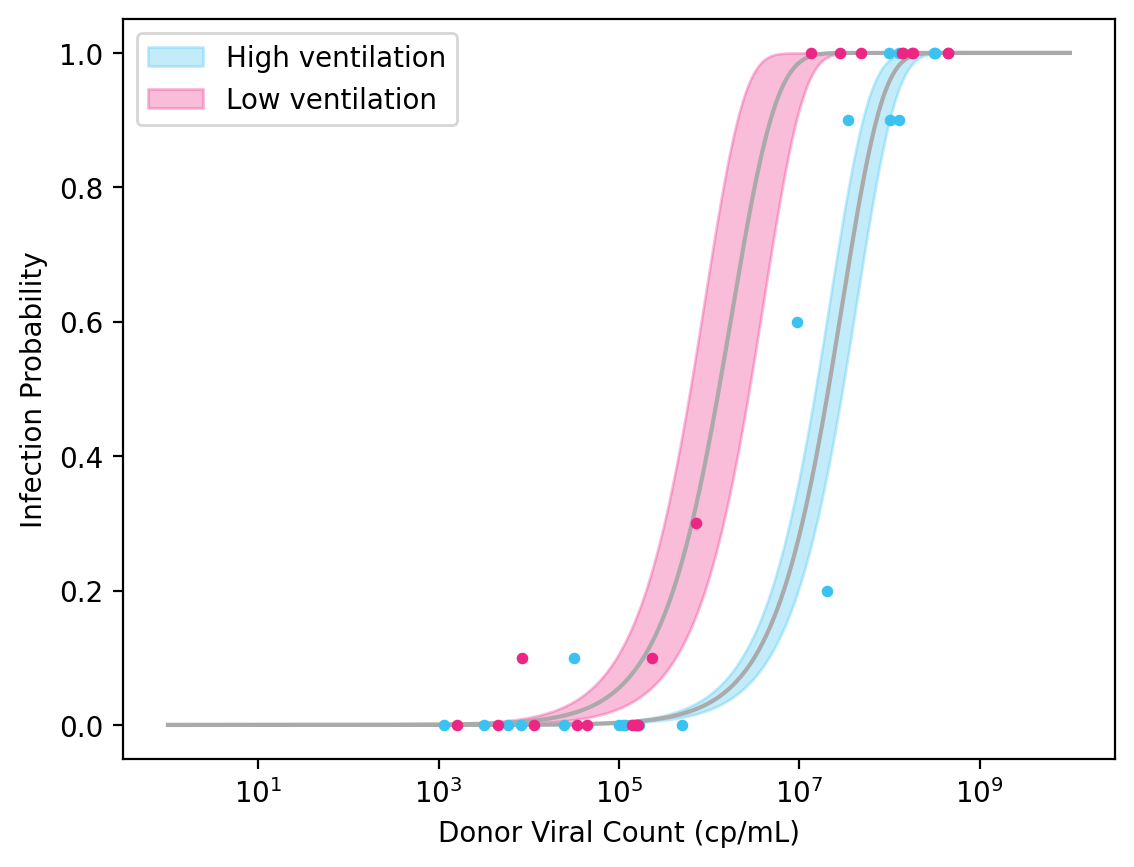

In [8]:
run_hierarchical_approach(
    num_donors = 20,
    num_recipients_per_donor = 10,
    suscept_sd = 0, # no susceptibility variance in simulations
    beta_lo = 1/3 * 1e-7,
    beta_hi = 3 * 1e-7,
    include_susceptibilities_fits = False,  # no susceptibility variance in model fits
)

### Simulation and model assume there is variance in susceptibility

/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_suscept, suscept_sd, log_beta]
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 

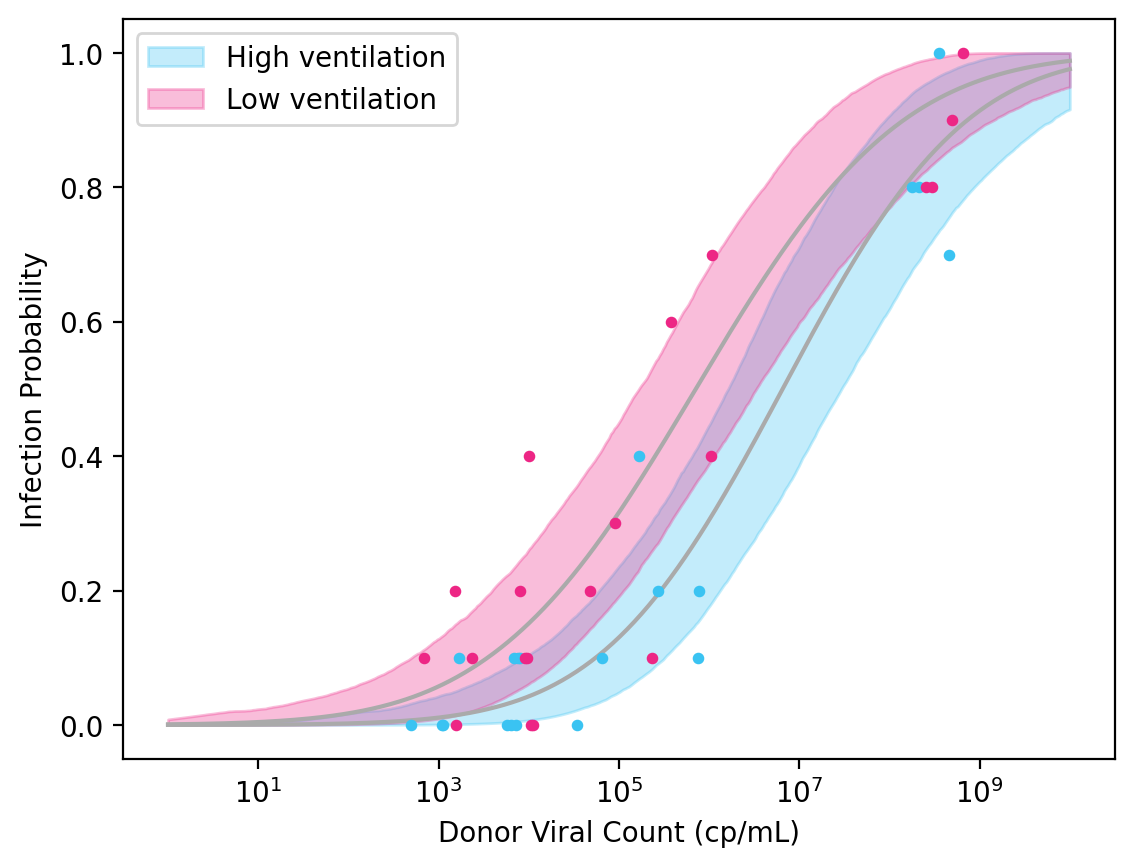

In [9]:
run_hierarchical_approach(
    num_donors = 20,
    num_recipients_per_donor = 10,
    suscept_sd = 2,  # susceptibility variance in simulations
    beta_lo = 1/3 * 1e-7,
    beta_hi = 3 * 1e-7,
    include_susceptibilities_fits = True,  # susceptibility variance in simulations
)

# Power analysis

In [10]:
def logistic(x: np.array, k: float, x0: float):
    """Logistic function with max fixed at 1.0"""
    return 1 / (1 + np.exp(-k * (x - x0)))

def combined_error(params: List[float], x1: np.array, y1: np.array, x2: np.array, y2: np.array):
    """Combined error function for two jointly fit logistic functions sharing the same k parameter"""
    k, x01, x02 = params
    error1 = np.sum((logistic(x1, k, x01) - y1) ** 2)
    error2 = np.sum((logistic(x2, k, x02) - y2) ** 2)
    return error1 + error2


def random_swap_arrays(arr1: np.array, arr2: np.array):
    """Shuffle the values between two arrays for a permutation test"""

    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must be of the same size.")

    # Randomly choose which array to pick the first element from for each position
    choices = np.random.choice([0, 1], size=len(arr1))

    # Create output arrays
    output1 = np.where(choices == 0, arr1, arr2)
    output2 = np.where(choices == 0, arr2, arr1)

    return output1, output2


def joint_logistic_fit(log_cpml_lo: np.array, log_cpml_hi: np.array, infection_rates_lo: np.array, infection_rates_hi: np.array):
    """
    Jointly fit two logistic functions with the same k parameter
    - log_cpml_lo is an array of the log viral rates of the donors (in cp/mL) under low transmission conditions
    - log_cpml_hi is an array of the log viral rates of the donors (in cp/mL) under high transmission conditions
    - infection_rates_lo is a list of infection rates for the donors under low transmission conditions
    - infection_rates_hi is a list of infection rates for the donors under high transmission conditions
    """
    initial_guess = [2, 5, 5]
    result = minimize(combined_error, initial_guess, args=(log_cpml_lo, infection_rates_lo, log_cpml_hi, infection_rates_hi))
    
    k_opt, x01_opt, x02_opt = result.x
    k_opt, x01_opt, x02_opt
    
    return {
        'k_opt': k_opt,
        'x01_opt': x01_opt, # h
        'x02_opt': x02_opt,
        'diff': x02_opt - x01_opt
    }

    
def get_logistic_p_value(actual_diff: float,
                         log_cpml_lo: np.array,
                         log_cpml_hi: np.array,
                         infection_rates_lo: np.array,
                         infection_rates_hi: np.array):
    """
    Permutation test on the difference in horizontal offset parameters between the two logistic functions
    """
    null_diffs = []
    for iter in range(250):
        permuted_infection_rates_lo, permuted_infection_rates_hi = random_swap_arrays(infection_rates_lo, infection_rates_hi)
        permuted_logistic_params = joint_logistic_fit(log_cpml_lo, log_cpml_hi, permuted_infection_rates_lo, permuted_infection_rates_hi)
        null_diffs.append(permuted_logistic_params['diff'])
    null_diffs = sorted(null_diffs)
    p = bisect(null_diffs, actual_diff) / len(null_diffs)
    return p
    

def plot_logistic(log_cpml_lo: np.array,
                  log_cpml_hi: np.array,
                  infection_rates_lo: np.array,
                  infection_rates_hi: np.array,
                  logistic_params: Dict, title=None):
    """
    - log_cpml_lo is an array of the log viral rates of the donors (in cp/mL) under low transmission conditions
    - log_cpml_hi is an array of the log viral rates of the donors (in cp/mL) under high transmission conditions
    - infection_rates_lo is a list of infection rates for the donors under low transmission conditions
    - infection_rates_hi is a list of infection rates for the donors under high transmission conditions
    - logistic_params is a dict of fitted logistic params
    """
    
    log_viral_count_range = np.linspace(0, 10, 5000)
    plt.scatter(log_cpml_lo, infection_rates_lo, label='High ventilation', color=pink) # 'lo' transmission is "High" ventilation
    plt.scatter(log_cpml_hi, infection_rates_hi, label='Low ventilation', color=blue) # 'hi' transmission is "Low" ventilation
    plt.plot(log_viral_count_range, logistic(log_viral_count_range, logistic_params['k_opt'], logistic_params['x01_opt']), color=pink)
    plt.plot(log_viral_count_range, logistic(log_viral_count_range, logistic_params['k_opt'], logistic_params['x02_opt']), color=blue)
    xticks = plt.xticks()
    plt.xticks(xticks[0], [f'$10^{{{int(x)}}}$' for x in xticks[0]])
    plt.xlabel('Donor viral count (cp/mL)')
    plt.ylabel('Transmission rate')
    plt.legend()
    plt.title(title)

In [11]:
def run_power_analysis(num_donors=20,
                       num_recipients_per_donor=10,
                       suscept_sd=0.5,
                       beta_lo=0.5 * 1e-7, # low transmission conditions
                       beta_hi=2 * 1e-7, # high transmission conditions
                       niter=30,
                       repeated_measures=True, # Whether to use the same donor in different conditions
                       tests={'joint logistic', 't-test', 'paired t-test', 'wilcoxon'},
                      ) -> Dict:

    if not repeated_measures and ('paired t-test' in tests or 'wilcoxon' in tests):
        raise ValueError('Paired t-test and Wilcoxon test can only be used in repeated measures designs!')

    significance_lists = dict()
    for test_name in tests:
        significance_lists[test_name] = []
    
    for iter in range(niter):
        recipient_counts = np.array([num_recipients_per_donor] * num_donors)

        log_cpml_lo, flattened_cpml_lo = generate_donor_cpml(num_donors, recipient_counts)
        if repeated_measures:
            log_cpml_hi, flattened_cpml_hi = log_cpml_lo, flattened_cpml_lo
        else:
            log_cpml_hi, flattened_cpml_hi = generate_donor_cpml(num_donors, recipient_counts)

        infection_counts_lo, infections_lo = simulate_experiment(flattened_cpml_lo, recipient_counts, 
                                                                 suscept_sd=suscept_sd, beta=beta_lo)
        infection_counts_hi, infections_hi = simulate_experiment(flattened_cpml_hi, recipient_counts, 
                                                                 suscept_sd=suscept_sd, beta=beta_hi)
        infection_rates_lo = infection_counts_lo / recipient_counts
        infection_rates_hi = infection_counts_hi / recipient_counts

        in_expected_direction = infection_rates_hi.mean() > infection_rates_lo.mean()
        
        if 'joint logistic' in tests:
            logistic_params = joint_logistic_fit(log_cpml_lo, log_cpml_hi, infection_rates_lo, infection_rates_hi)
            p = get_logistic_p_value(logistic_params['diff'], log_cpml_lo, log_cpml_hi, infection_rates_lo, infection_rates_hi)
            is_significant = p < .05 and in_expected_direction
            significance_lists['joint logistic'].append(is_significant)
        if 't-test' in tests:
            res = ttest_ind(infection_rates_lo, infection_rates_hi)
            is_significant = res.pvalue < .05 and in_expected_direction
            significance_lists['t-test'].append(is_significant)
        if 'paired t-test' in tests:
            res = ttest_rel(infection_rates_lo, infection_rates_hi)
            is_significant = res.pvalue < .05 and in_expected_direction
            significance_lists['paired t-test'].append(is_significant)
        if 'wilcoxon' in tests:
            if (infection_rates_lo == infection_rates_hi).all():
                is_significant = False
            else:
                res = wilcoxon(infection_rates_lo, infection_rates_hi)
                is_significant = res.pvalue < .05 and in_expected_direction
            significance_lists['wilcoxon'].append(is_significant)
            
    if 'joint logistic' in tests:
        last_iter_logistic_params = logistic_params
    else:
        last_iter_logistic_params = {}

    powers = {}
    for test_name in tests:
        powers[test_name] = np.array(significance_lists[test_name]).mean()

    return  {
            'log_cpml_lo': log_cpml_lo,
            'log_cpml_hi': log_cpml_hi,
            'infection_rates_lo': infection_rates_lo,
            'infection_rates_hi': infection_rates_hi,
            'last_iter_logistic_params': last_iter_logistic_params,
            'powers': powers,
    }

### Non-repeated measures designs

In [13]:
res = run_power_analysis(
                   num_donors=300,
                   num_recipients_per_donor=10,
                   suscept_sd=0.0,
                   beta_lo=0.5 * 1e-7,
                   beta_hi=2 * 1e-7,
                   niter=400,
                   repeated_measures=False,
                   tests={'t-test', 'joint logistic'})

Powers
 {'t-test': 0.805, 'joint logistic': 0.9975}


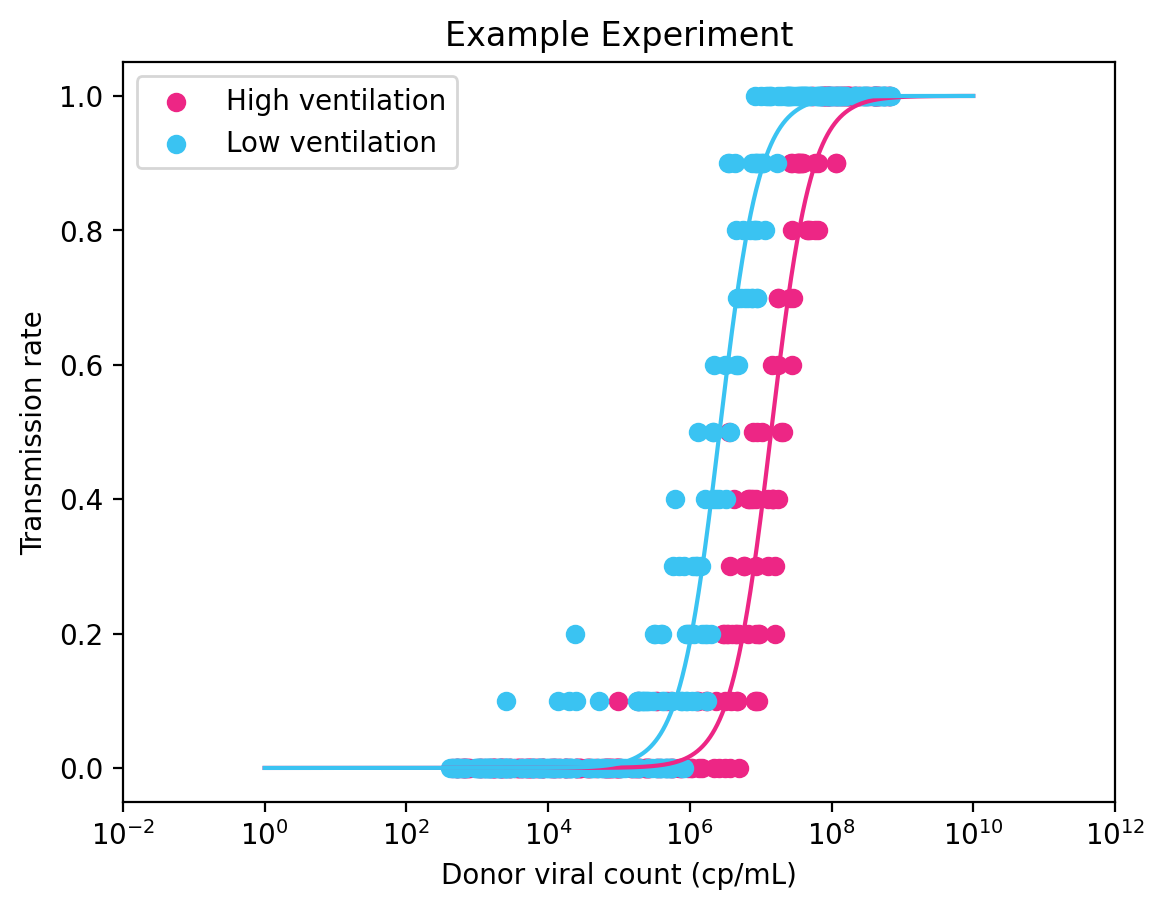

In [14]:
print('Powers\n', res['powers'])
plot_logistic(res['log_cpml_lo'], res['log_cpml_hi'], res['infection_rates_lo'], res['infection_rates_hi'], res['last_iter_logistic_params'], title='Example Experiment')

In [15]:
res = run_power_analysis(
                   num_donors=40,
                   num_recipients_per_donor=10,
                   suscept_sd=0.0,
                   beta_lo=0.5 * 1e-7,
                   beta_hi=2 * 1e-7,
                   niter=400,
                   repeated_measures=False,
                   tests={'t-test', 'joint logistic'})

/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))
/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))
/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))
/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))
/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))
/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0))

Powers
 {'t-test': 0.17, 'joint logistic': 0.745}


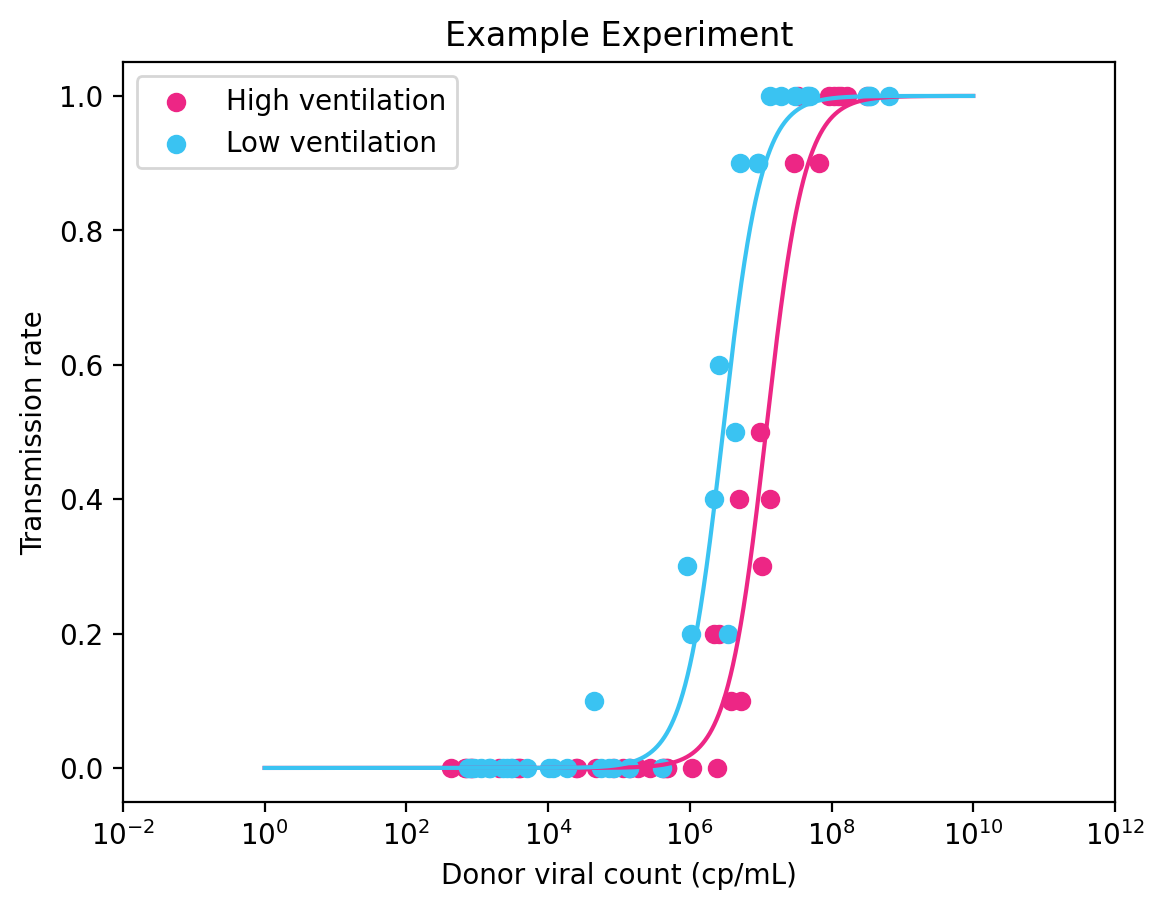

In [16]:
print('Powers\n', res['powers'])
plot_logistic(res['log_cpml_lo'], res['log_cpml_hi'], res['infection_rates_lo'], res['infection_rates_hi'], res['last_iter_logistic_params'], title='Example Experiment')

### Repeated measures, no variability in susceptibility

In [17]:
res = run_power_analysis(
                   num_donors=20,
                   num_recipients_per_donor=10,
                   suscept_sd=0.0,
                   beta_lo=0.5 * 1e-7,
                   beta_hi=2 * 1e-7,
                   niter=200)

/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))
/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))
/var/folders/36/d986lkt97qg66yj_6wt5x8t80000gn/T/ipykernel_11073/2508247923.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k *

Powers
 {'t-test': 0.005, 'wilcoxon': 0.805, 'joint logistic': 0.795, 'paired t-test': 0.795}


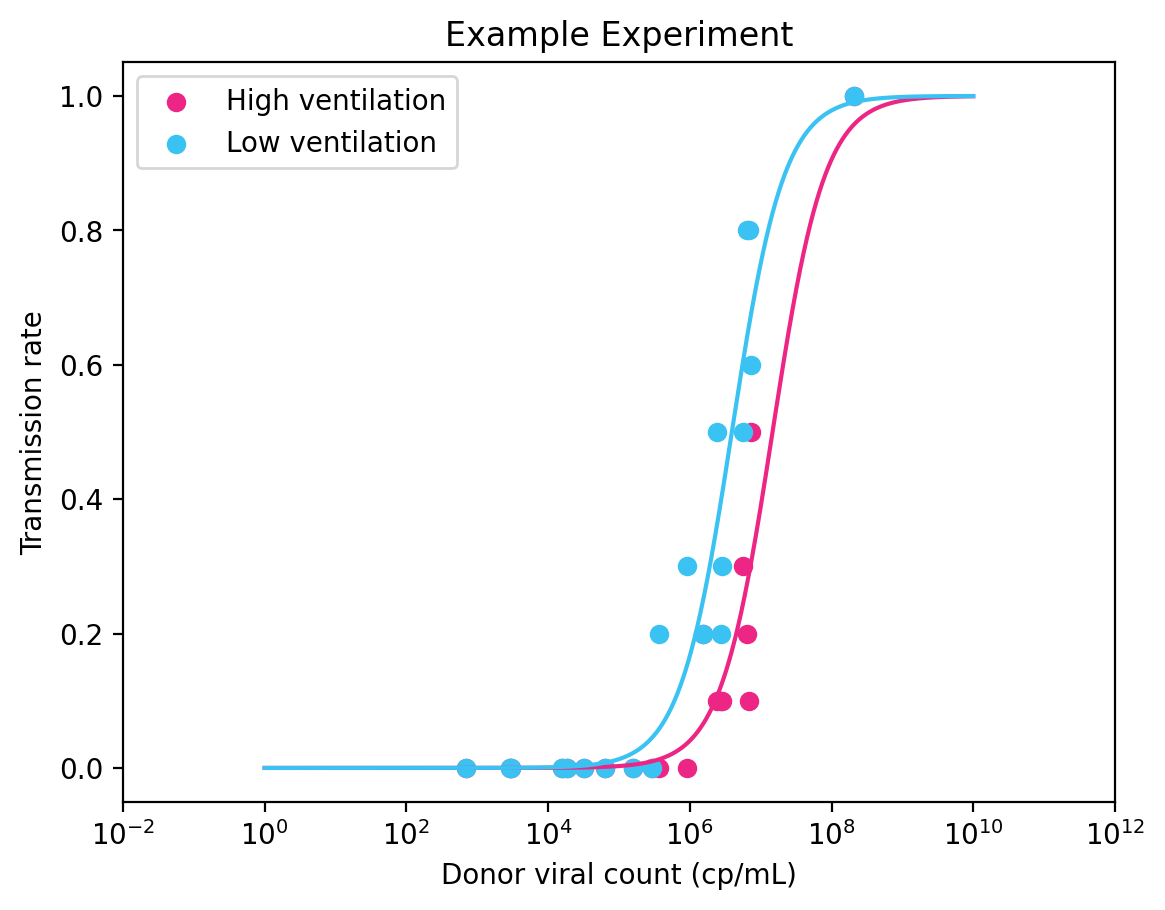

In [18]:
print('Powers\n', res['powers'])
plot_logistic(res['log_cpml_lo'], res['log_cpml_hi'], res['infection_rates_lo'], res['infection_rates_hi'], res['last_iter_logistic_params'], title='Example Experiment')

### Repeated measures variability in susceptibility
Variability in susceptibility hurts insofar as it adds variance to the infection rates, but it also helps insofar as it brings some very high viral count and very low viral count donors into play, who ordinarily would have 100% or 0% infection rates and therefore not be that informative.

In [19]:
res = run_power_analysis(
                   num_donors=20,
                   num_recipients_per_donor=10,
                   suscept_sd=1.5,
                   beta_lo=0.5 * 1e-7,
                   beta_hi=2 * 1e-7,
                   niter=200)

Powers
 {'t-test': 0.005, 'wilcoxon': 0.52, 'joint logistic': 0.625, 'paired t-test': 0.555}


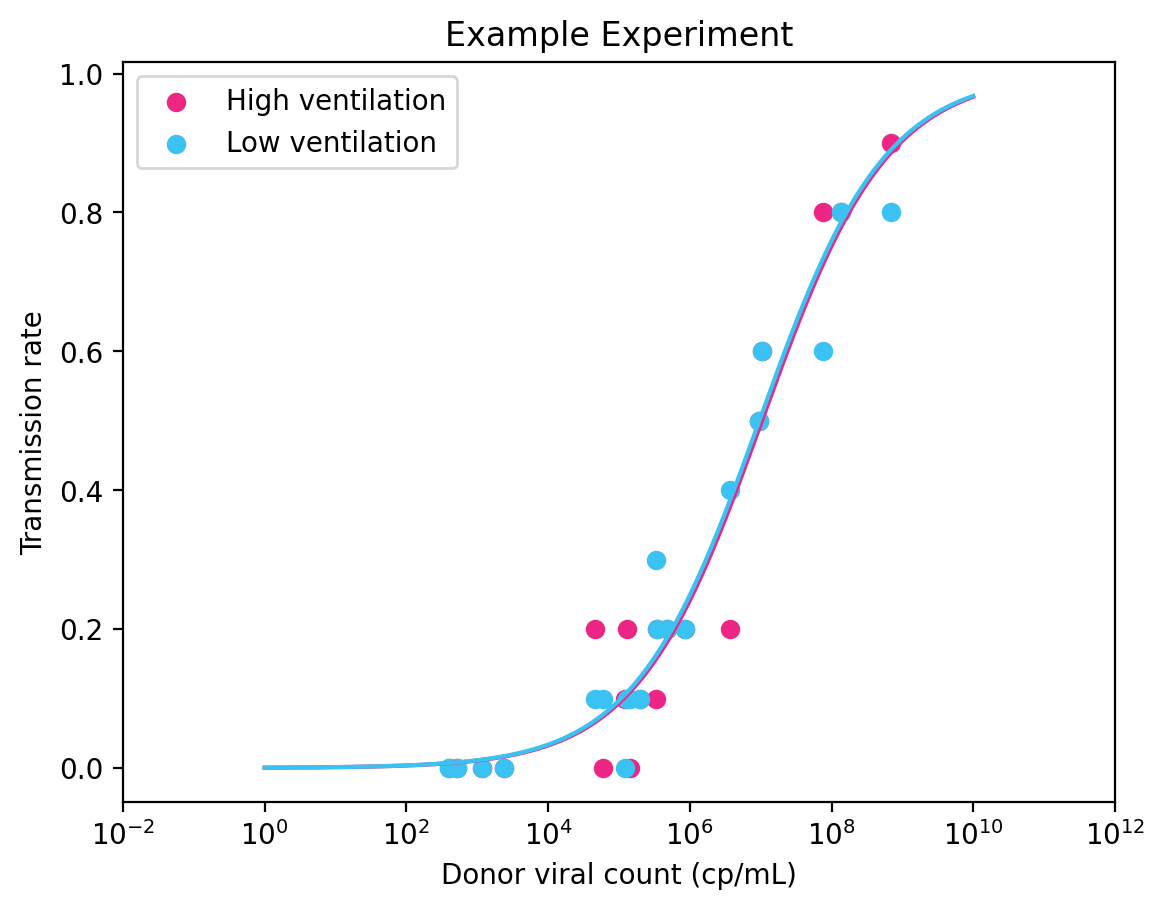

In [20]:
print('Powers\n', res['powers'])
plot_logistic(res['log_cpml_lo'], res['log_cpml_hi'], res['infection_rates_lo'], res['infection_rates_hi'], res['last_iter_logistic_params'], title='Example Experiment')

## Power curves

In [21]:
def generate_power_curves(num_donors_list: Sequence[int],
                          num_recipients_per_donor_list: Sequence[int],
                          beta_lo=0.5 * 1e-7,
                          beta_hi=2 * 1e-7,
                          suscept_sd=0,
                          niter=3000):
    
    power_curves = {}
    for num_donors in num_donors_list:
        power_curves[num_donors] = []
        for num_recipients_per_donor in num_recipients_per_donor_list:
            res = run_power_analysis(
                               num_donors=num_donors,
                               num_recipients_per_donor=num_recipients_per_donor,
                               suscept_sd=suscept_sd,
                               beta_lo=beta_lo,
                               beta_hi=beta_hi,
                               niter=niter,
                               tests={'wilcoxon'})
            power_curves[num_donors].append(res['powers']['wilcoxon'])
    return power_curves

def plot_power_curves(num_donors_list: Sequence[int],
                      num_recipients_per_donor_list: Sequence[int],
                      power_curves: Sequence[float],
                      quanta_reduction: str):
    for num_donors in num_donors_list:
        plt.plot(num_recipients_per_donor_list, power_curves[num_donors], label=f'Number of donors={num_donors}')
    plt.legend()
    plt.xlabel('Recipients per <donor, condition>')
    plt.ylabel('Power')
    sns.despine()
    plt.title(f'For {quanta_reduction} reduction in inhaled virus')

In [22]:
num_donors_list = [40, 20, 10, 5]
num_recipients_per_donor_list = np.arange(3, 20)

#### Assuming 4x differences

In [23]:
power_curves = generate_power_curves(num_donors_list,
                                     num_recipients_per_donor_list,
                                     beta_lo=0.5 * 1e-7,
                                     beta_hi=2.0 * 1e-7)


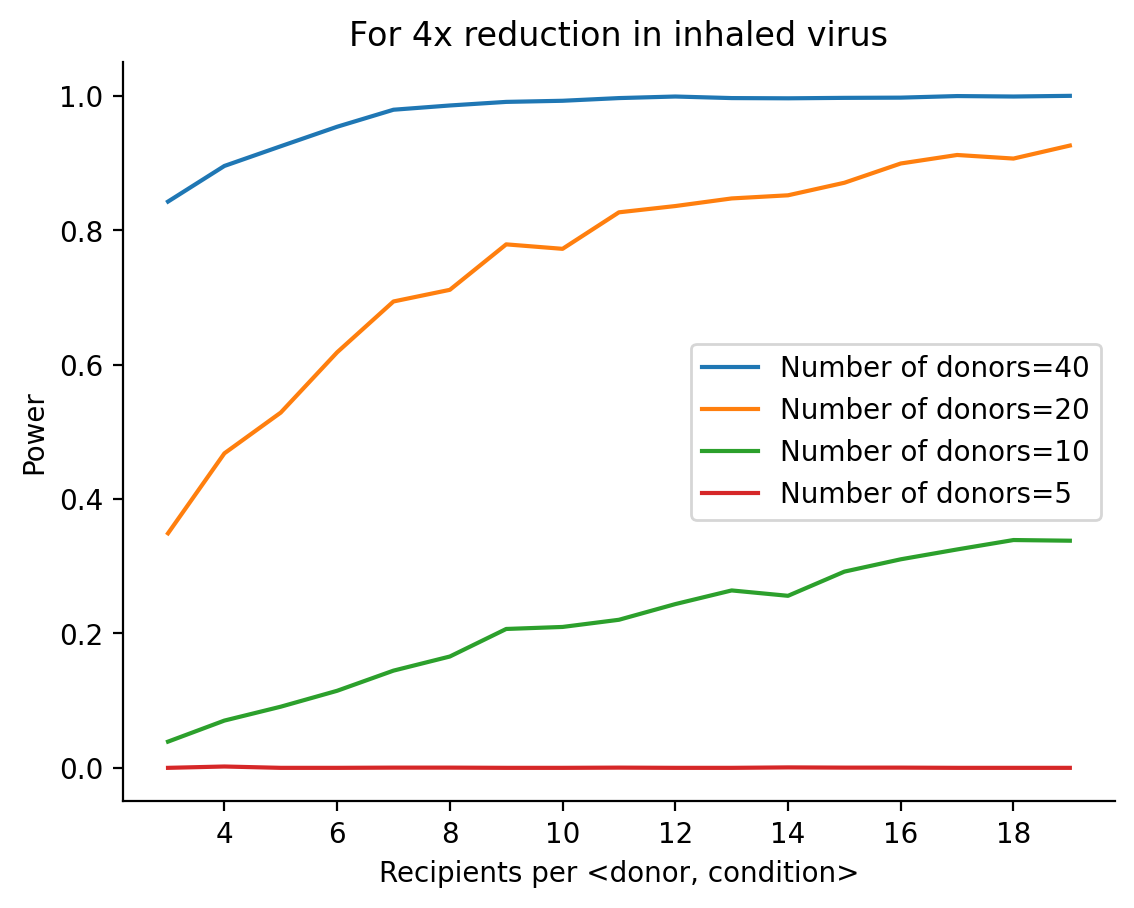

In [24]:
plot_power_curves(num_donors_list, num_recipients_per_donor_list, power_curves, quanta_reduction='4x')

#### Assuming 10x differences

In [25]:
power_curves = generate_power_curves(num_donors_list,
                                     num_recipients_per_donor_list,
                                     beta_lo=1/np.sqrt(10) * 1e-7,
                                     beta_hi=np.sqrt(10) * 1e-7)


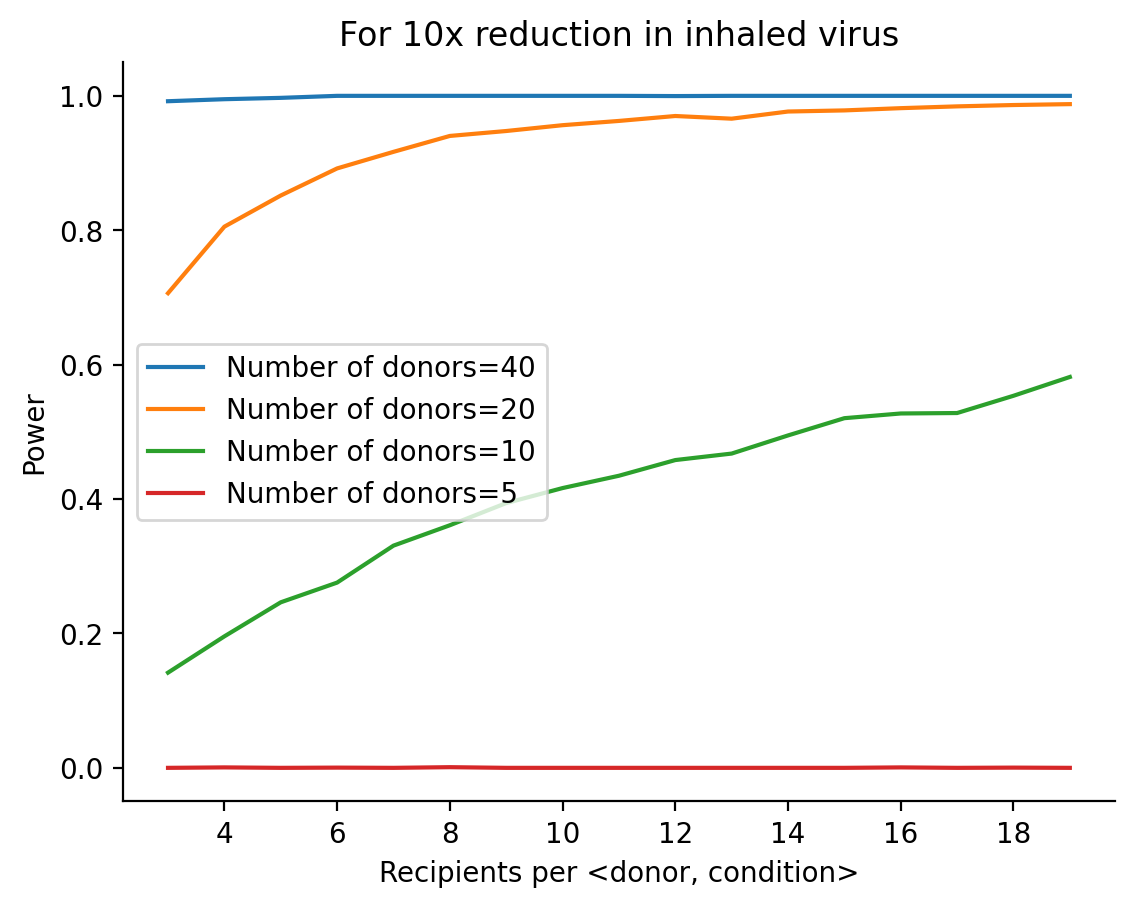

In [26]:
plot_power_curves(num_donors_list, num_recipients_per_donor_list, power_curves, quanta_reduction='10x')

## Generalization

### Assuming no variance in susceptibility
Every 10x improvement in $\beta$ shifts the curve by 1 log

In [53]:
def plot_multi_curves(betas, labels):
    sns.set_style('whitegrid')

    cmap = matplotlib.colormaps['YlOrRd']    
    viral_count_range = 10**np.linspace(0, 10, 100)
    colors = [cmap(value) for value in np.linspace(1,.3,len(betas))]
    for color, beta, label in zip(colors, betas, labels):
        lmbd = get_hazard(viral_count_range, beta=beta)
        p = 1 - np.exp(-lmbd)
        plt.plot(viral_count_range, p, color=color, label=label)
    plt.xscale("log")
    sns.set_style('white')
    plt.ylabel('Infection Probability')
    plt.xlabel('Viral Count (cp/mL)')
    plt.legend()
    sns.set_style('white')


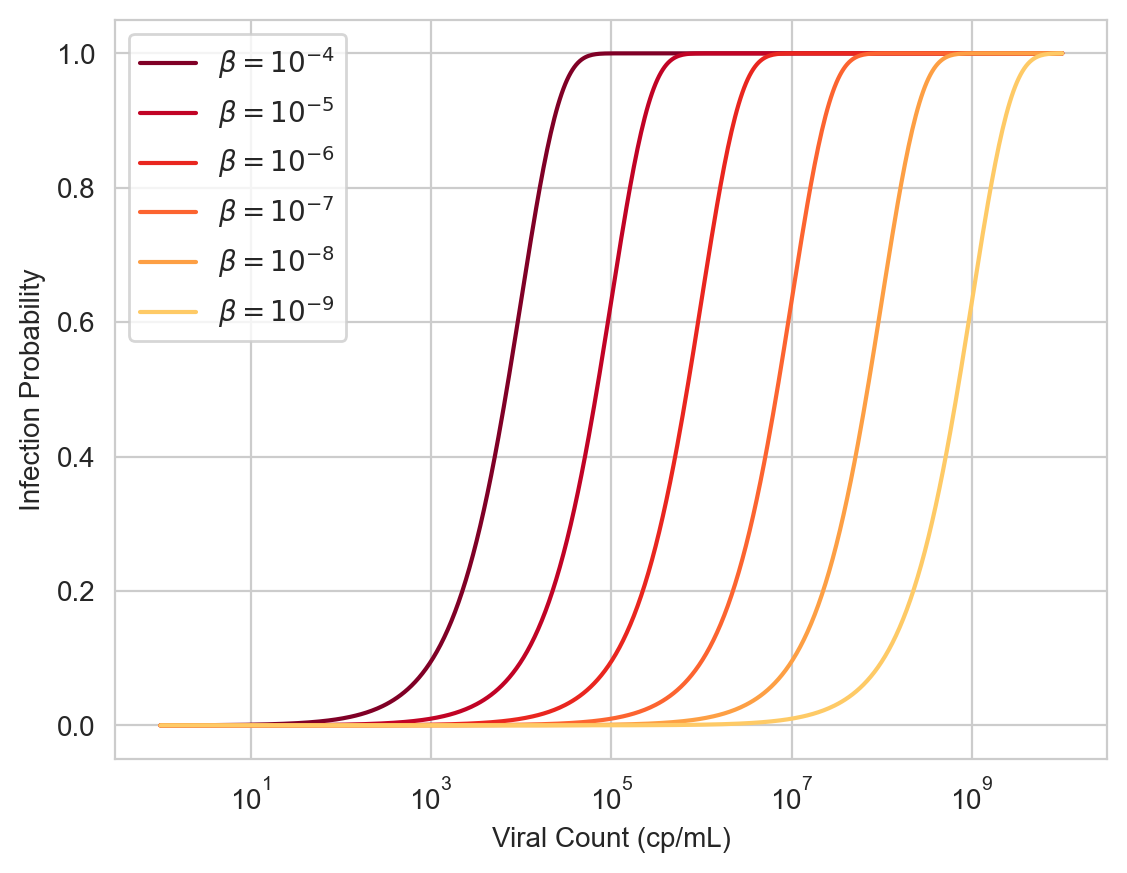

In [49]:
exponents = [-4, -5, -6, -7, -8, -9]
betas = list(10.**np.array(exponents))
labels = [f"$\\beta=10^{{{exponent}}}$" for exponent in exponents]
plot_multi_curves(betas, labels)

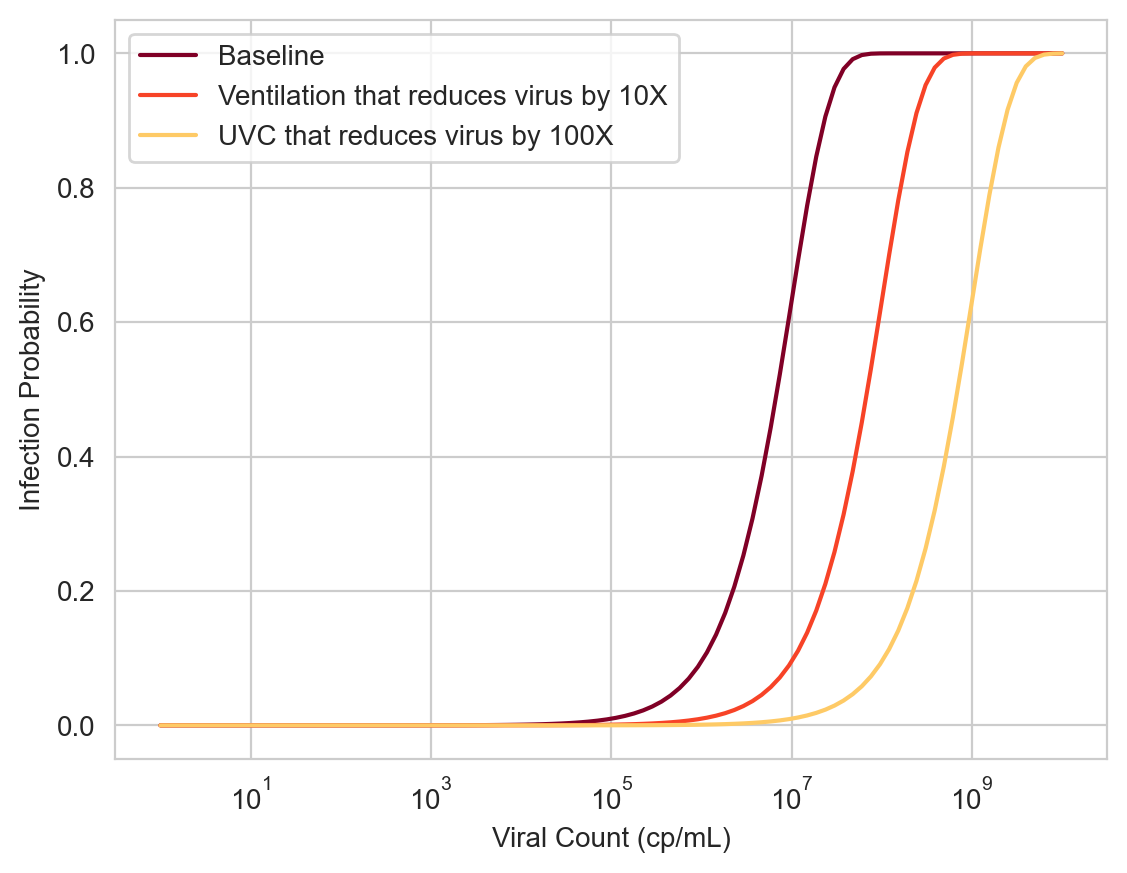

In [55]:
exponents = [-7, -8, -9]
betas = list(10.**np.array(exponents))
labels = ['Baseline', 'Ventilation that reduces virus by 10X', 'UVC that reduces virus by 100X']
plot_multi_curves(betas, labels)

### Assuming some variance in susceptibility
Even when there is variance in susceptibility, every 10x improvement in $\beta$ shifts the curve by 1 log

Could sample from my mcmc trace, but easier to just simulate the experiments

In [30]:
def get_infection_rates(
    num_donors,
    num_recipients_per_donor,
    recipient_counts,
    flattened_cpml,
    suscept_sd = 2,
    beta = 1/3 * 1e-7,
    ):
    
    
    infection_counts, infections = simulate_experiment(flattened_cpml, recipient_counts, 
                                                             suscept_sd=suscept_sd, beta=beta)
    infection_rates = np.array(infection_counts) / num_recipients_per_donor
    return infection_rates 


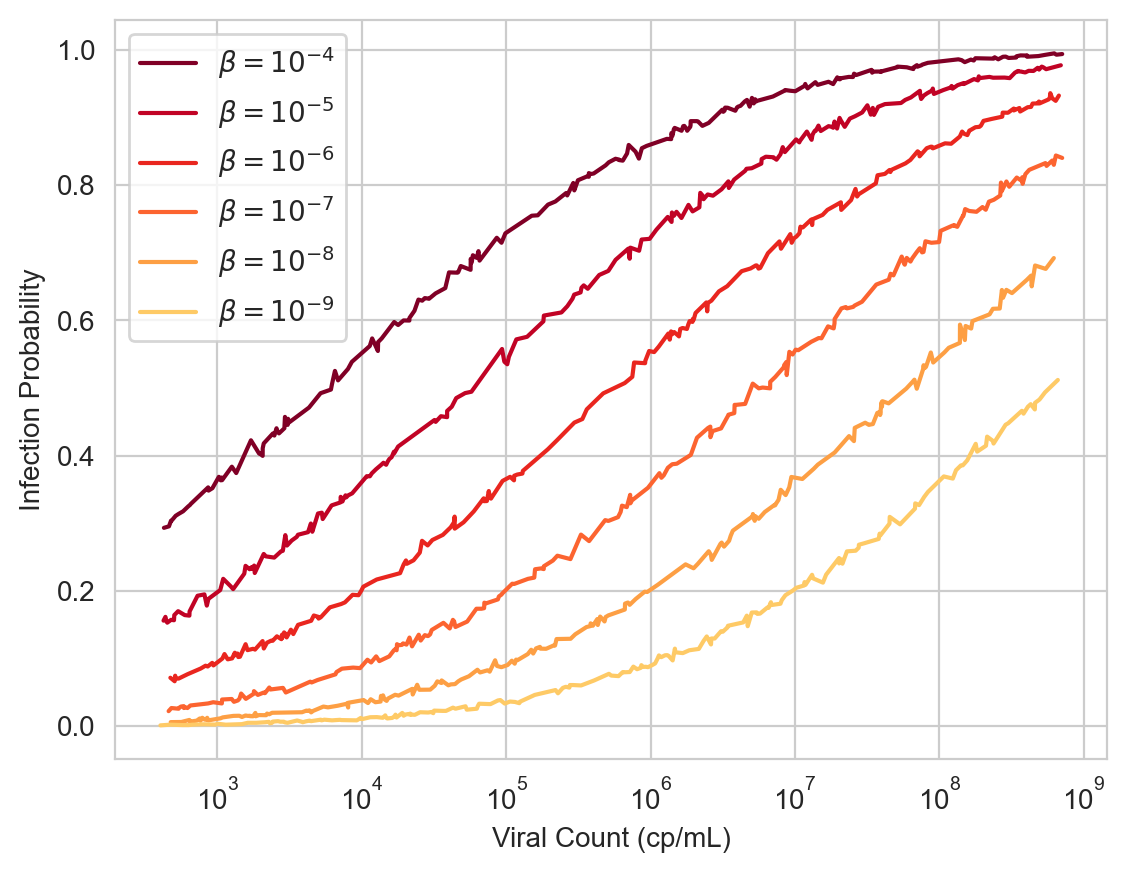

In [54]:
sns.set_style('whitegrid')
num_donors = 200
num_recipients_per_donor = 5000
suscept_sd = 2
exponents = [-4, -5, -6, -7, -8, -9]
betas = list(10.**np.array(exponents))

cmap = matplotlib.colormaps['YlOrRd']    
colors = [cmap(value) for value in np.linspace(1,.3,len(betas))]
labels = [f"$\\beta=10^{{{exponent}}}$" for exponent in exponents]

for color, label, beta in zip(colors, labels, betas):
    recipient_counts = np.array([num_recipients_per_donor] * num_donors)
    log_cpml, flattened_cpml = generate_donor_cpml(num_donors, recipient_counts)
    infection_rates = get_infection_rates(num_donors, num_recipients_per_donor, recipient_counts, flattened_cpml, suscept_sd, beta=beta)
    plt.plot(10**log_cpml, infection_rates, color=color, label=label)
plt.xscale("log")
plt.ylabel('Infection Probability')
plt.xlabel('Viral Count (cp/mL)')
plt.legend()
sns.set_style('white')